# Generative Adversarial Networks

Unless you've been sleeping under a rock, you've probably encountered [Generative Adversarial Networks](https://arxiv.org/abs/1406.2661) before. At least you've seen the pictures. For instance, you can create fake images of bedrooms, as done in [this paper](https://arxiv.org/pdf/1511.06434.pdf) by Radford et al. in 2015. 

![](img/fake_bedrooms.png)

At their heart GANs use the notion that a data generator is good, if we cannot tell fake data apart from real data. In statistics this is called a two-sample test - a test to answer the question whether datasets $X = \{x_1, \ldots x_n\}$ and $X' = \{x_1', \ldots x_n'\}$ were drawn from the same distribution. The main difference to most statistics papers is that GANs use this idea in a constructive way. In other words, rather than just telling a user that 'hey, these two datasets don't look like they came from the same distribution', this allows us to improve the data generator until it is close to the real data. Or at least indistinguishable from it, as far as a classifier is concerned. 

As you can see, there are two pieces to GANs - first off, we need a device (say, a deep network but it really could be anything, such as a game rendering engine) that might potentially be able to generate data that looks just like the real thing. Obviously, if we are dealing with images, this needs to generate images. If we're dealing with speech, it needs to generate audio sequences, and so on. We call this the *generator network*. The second component is the *adversarial network*. It attempts to distinguish fake and real data from each other. Both networks are in competition with each other. The generator network attempts to fool the discriminator. At that point, the discriminator network adapts to the new fake data. This information, in turn is used to improve the generator network, and so on. 

**Generator**
* Draw some parameter $u$ from a source of randomness, e.g. a normal distribution $u \sim \mathcal{N}(0,1)$.
* Apply a function $f$ such that we get $x' = g(u,w)$
* Compute the gradient with respect to $w$ to minimize $\log p(y = \mathrm{fake}|x')$ 

**Discriminator**
* Improve the accuracy of a binary classifier $f$, i.e. maximize $\log p(y=\mathrm{fake}|x')$ and $\log p(y=\mathrm{true}|x)$ for fake and real data respectively.

In short, there are two optimization problems running simultaneously, and the optimization terminates if a stalemate has been reached. There are lots of further tricks and details on how to modify this basic setting. For instance, we could try solving this problem in the presence of side information. This leads to cGAN, i.e. conditional Generative Adversarial Networks. We can change the way how to we detect whether real and fake data look the same. This leads to wGAN (Wasserstein GAN), kernel-inspired GANs and lots of other settings, or we could change how closely we look at the objects. E.g. fake images might look real at the texture level but not so at the larger level, or vice versa. 

Many of the applications are in the context of images. Since this takes too much time to solve in a Jupyter notebook on a laptop, we're going to content ourselves with fitting much simpler distribution. We will illustrate what happens if we use GANs to build the world's most inefficient estimator of parameters for a Gaussian. Let's get started.


In [1]:
from __future__ import print_function
import matplotlib as mpl
from matplotlib import pyplot as plt

import mxnet as mx
from mxnet import gluon
from mxnet import ndarray as nd
from mxnet.gluon import nn
from mxnet import autograd
import numpy as np

ctx = mx.cpu()

## Generate some 'real' data

Since this is going to be the world's lamest example, we simply generate data drawn from a Gaussian. And let's also set a context where we'll do most of the computation.

In [2]:
X = nd.random_normal(shape=(1000, 2))
A = nd.array([[1, 2], [-0.1, 0.5]])
b = nd.array([1, 2])
X = nd.dot(X,A) + b
Y = nd.ones(shape=(1000,1))

# and stick them into an iterator
batch_size = 4
train_data = mx.io.NDArrayIter(X, Y, batch_size, shuffle=True)

Let's see what we got. This should be a Gaussian shifted in some rather arbitrary way with mean $b$ and covariance matrix $A^\top A$.

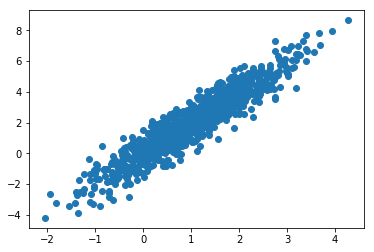

The covariance matrix is

[[ 5.          0.89999998]
 [ 0.89999998  0.25999999]]
<NDArray 2x2 @cpu(0)>


In [3]:
plt.scatter(X[:, 0].asnumpy(),X[:,1].asnumpy())
plt.show()
print("The covariance matrix is")
print(nd.dot(A, A.T))

## Defining the networks

Next we need to define how to fake data. Our generator network will be the simplest network possible - a single layer linear model. This is since we'll be driving that linear network with a Gaussian data generator. Hence, it literally only needs to learn the parameters to fake things perfectly. For the discriminator we will be a bit more discriminating: we will use an MLP with 3 layers to make things a bit more interesting. 

The cool thing here is that we have *two* different networks, each of them with their own gradients, optimizers, losses, etc. that we can optimize as we please. 

In [4]:
# build the generator
netG = nn.Sequential()
netG.add(nn.Dense(2))

# build the discriminator (with 5 and 3 hidden units respectively)
netD = nn.Sequential()
netD.add(nn.Dense(5, activation='tanh'))
netD.add(nn.Dense(3 ,activation='tanh'))
netD.add(nn.Dense(2))

# loss
loss = gluon.loss.SoftmaxCrossEntropyLoss()

# initialize the generator and the discriminator
netG.initialize(mx.init.Normal(0.02), ctx=ctx)
netD.initialize(mx.init.Normal(0.02), ctx=ctx)

# trainer for the generator and the discriminator
trainerG = gluon.Trainer(netG.collect_params(), 'adam', {'learning_rate': 0.01})
trainerD = gluon.Trainer(netD.collect_params(), 'adam', {'learning_rate': 0.01})

## Setting up the training loop

We are going to iterate over the data a few times. To make life simpler we need a few variables

In [ ]:
real_label = mx.nd.ones((batch_size,), ctx=ctx)
fake_label = mx.nd.zeros((batch_size,), ctx=ctx)
metric = mx.metric.Accuracy()

# set up logging
from datetime import datetime
import os
import time

## Training loop




binary training acc at epoch 0: accuracy=0.711000
time: 2.581147


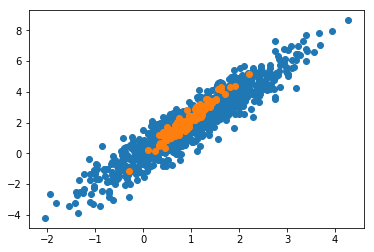


binary training acc at epoch 1: accuracy=0.483000
time: 2.151945


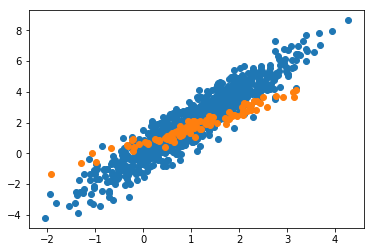


binary training acc at epoch 2: accuracy=0.431500
time: 2.556253


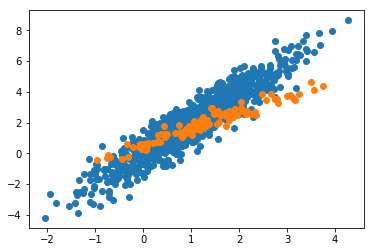


binary training acc at epoch 3: accuracy=0.430500
time: 2.049017


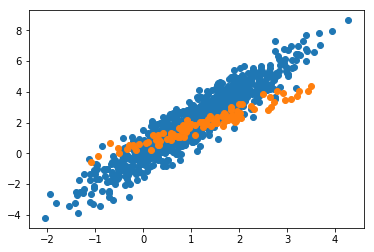


binary training acc at epoch 4: accuracy=0.420000
time: 2.847229


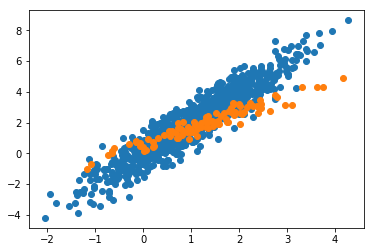


binary training acc at epoch 5: accuracy=0.418500
time: 2.069055


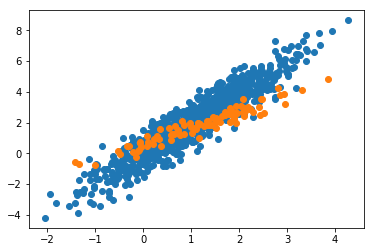


binary training acc at epoch 6: accuracy=0.408000
time: 1.926980


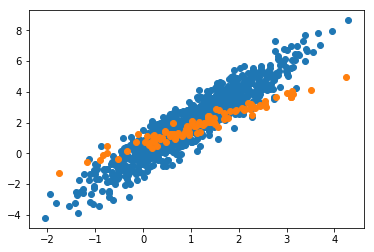


binary training acc at epoch 7: accuracy=0.393500
time: 2.187682


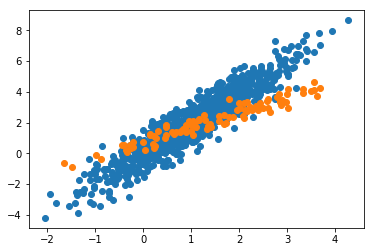


binary training acc at epoch 8: accuracy=0.400500
time: 1.897368


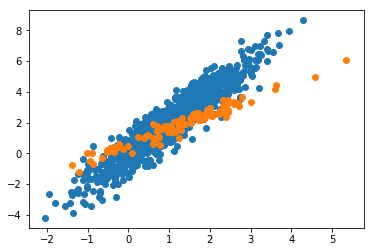

In [ ]:
stamp =  datetime.now().strftime('%Y_%m_%d-%H_%M')
for epoch in range(10):
    tic = time.time()
    btic = time.time()
    train_data.reset()
    for iter, batch in enumerate(train_data):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real_t
        data = batch.data[0].as_in_context(ctx)
        noise = mx.nd.random_normal(shape=(batch_size, 2), ctx=ctx)

        with autograd.record():
            output = netD(data)
            errD_real = loss(output, real_label)
            metric.update([real_label,], [output,])

            fake = netG(noise)
            output = netD(fake.detach())
            errD_fake = loss(output, fake_label)
            errD = errD_real + errD_fake
            errD.backward()
            metric.update([fake_label,], [output,])

        trainerD.step(batch_size)

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        with autograd.record():
            output = netD(fake)
            errG = loss(output, real_label)
            errG.backward()

        trainerG.step(batch_size)

        name, acc = metric.get()
        # logging.info('speed: {} samples/s'.format(opt.batch_size / (time.time() - btic)))
        # print('discriminator loss = %f, generator loss = %f, binary training acc = %f at iter %d epoch %d' %(mx.nd.mean(errD).asscalar(), mx.nd.mean(errG).asscalar(), acc, iter, epoch))
        
        iter = iter + 1
        btic = time.time()

    name, acc = metric.get()
    metric.reset()
    print('\nbinary training acc at epoch %d: %s=%f' % (epoch, name, acc))
    print('time: %f' % (time.time() - tic))
    noise = mx.nd.random_normal(shape=(100, 2), ctx=ctx)
    fake = netG(noise)
    plt.scatter(X[:, 0].asnumpy(),X[:,1].asnumpy())
    plt.scatter(fake[:,0].asnumpy(),fake[:,1].asnumpy())
    plt.show()




## Checking the outcome

Let's now generate some fake data and check whether it looks real.

In [ ]:
noise = mx.nd.random_normal(shape=(100, 2), ctx=ctx)
fake = netG(noise)

plt.scatter(X[:, 0].asnumpy(),X[:,1].asnumpy())
plt.scatter(fake[:,0].asnumpy(),fake[:,1].asnumpy())
plt.show()



## Conclusion 

As you can see, even for a simple eample like linear regression, ``gluon`` can help you to write quick, clean, clode. Next, we'll repeat this exercise for multilayer perceptrons, extending these lessons to deep neural networks and (comparatively) real datasets. 

For whinges or inquiries, [open an issue on  GitHub.](https://github.com/zackchase/mxnet-the-straight-dope)